In [2]:
import matplotlib.pyplot as plt

from scipy.stats import lognorm

from astropy.io import ascii
import numpy as np
import astropy.units as u
import pandas as pd
from astropy.time import Time
from astropy.visualization import hist

from minicyclop.io import read_latest, read_seeing_data

%matplotlib widget

In [4]:
d = read_latest("/home/tim/MMT/minicyclop/data/MiniCyclop/Data/Last_Seeing_Data.txt")

In [5]:
d['obstime'] - Time.now()

<TimeDelta object: scale='tai' format='jd' value=-0.611495525076154>

In [6]:
df = read_seeing_data("/home/tim/MMT/minicyclop/data/MiniCyclop/Data/Seeing_Data.txt")

In [7]:
df

,flux,seeing,r0
UT,,,
6/8/2022 3:32:32 AM,2733.7,0.84,135.8
6/8/2022 3:33:27 AM,2755.7,0.84,134.4
6/8/2022 3:34:23 AM,2801.6,2.38,47.7
6/8/2022 3:35:16 AM,2853.2,1.01,112.3
6/8/2022 3:36:00 AM,2739.0,1.03,110.7
...,...,...,...
6/21/2022 10:02:42 AM,1448.8,1.04,109.3
6/21/2022 10:03:40 AM,1354.4,1.17,97.1
6/21/2022 10:05:51 AM,779.8,1.13,100.5


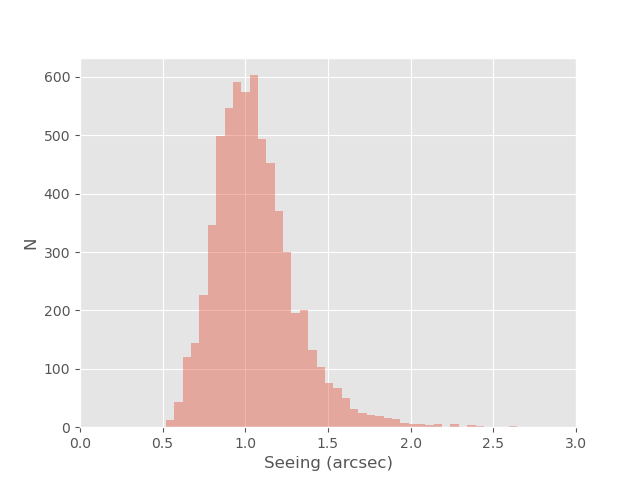

In [12]:
fig = plt.figure()
with plt.style.context('ggplot'):
    hist(df['seeing'], bins='scott', histtype='stepfilled', alpha=0.4)
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("N")
    plt.xlim([0.0, 3.0])
plt.show()

In [11]:
# fit a log-normal distribution to the seeing data
sigma, loc, exp_mu = lognorm.fit(df['seeing'])
print(sigma, loc, exp_mu)
x = np.arange(0.0, 4.0, 0.01)
p = lognorm.pdf(x, sigma, loc=loc, scale=exp_mu)
mu = np.log(exp_mu)
mode = np.exp(mu - sigma**2) + loc
median = np.nanmedian(df['seeing'])
fit_median = exp_mu + loc

0.3204587669798893 0.2978272198677676 0.7277884286465419


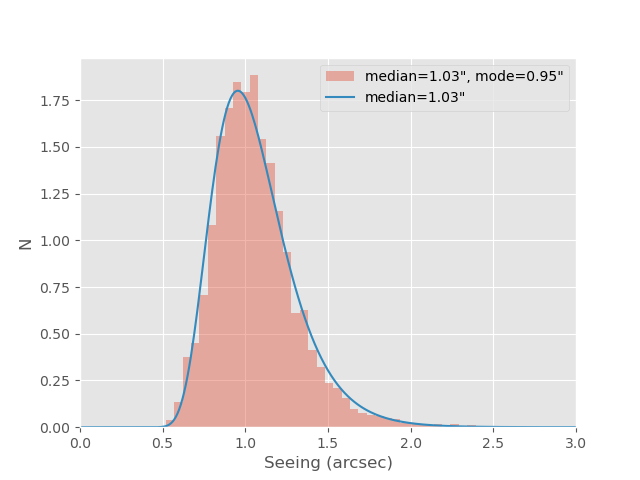

In [13]:
fig = plt.figure()
with plt.style.context('ggplot'):
    hist(df['seeing'], bins='scott', histtype='stepfilled', alpha=0.4, density=True)
    logp = plt.plot(x, p, label="logp")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("N")
    plt.xlim([0.0, 3.0])
    plt.legend(["median=%.2f\", mode=%.2f\"" % (fit_median, mode), "median=%.2f\"" % (
        median
    )])
plt.show()